# Pre vs Post Treatment Tests
- **Objective**: This test compares two states of the samples: before and after an intervention or treatment has been applied.
- Reference: 
    - [My Easy Guide to Pre vs. Post Treatment Tests](https://towardsdatascience.com/my-easy-guide-to-pre-vs-post-treatment-tests-0206f56f83a4)
## Problem Statement
- A grocery store chain observes a spike in some brands of coffee and wants to test whether it increases sales or not if they double the facings of these new best-performing brands to the customer.
    - Hence, they will select some stores at random as a treatment group and make that change.
- Summarizing
    - **Control Group**: Stores without change in the coffee section
    - **Treatment Group**: Stores with the redesigned coffee section
    - **Pre-Period**: a period before the intervention. 
        - The size of this period must be chosen taking into consideration the seasonality of the business and any other aspects that can affect the results, like sales, promotions, holidays, and weekends.
    - **Post Period**: the period after the intervention. The same is true for determining the size of the period
- Hypothesis:
    - Ho says that the treatment is not effective
    - Ha says that it is effective.

In [20]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import pingouin as pg
import matplotlib.pyplot as plt
import plotly.express as px


## Dataset Simulation
- To simulate a situation of Pre-Post intervention.

In [2]:
# Date: 
dates = pd.date_range(start='2024-01-01', end='2024-01-30')

# Stores IDs: 1000 stores in total
store_ids = range(1,1001,1)

# Control and Treat Group
np.random.seed(42)
group = np.random.choice(a=['Control', 'Treatment'], size=len(store_ids), p=[0.50, 0.50])

# Create dataframe: 1000 stores with 30 days - daily revenue
df = pd.DataFrame({'dt': list(dates)*1000,'store_id': list(store_ids)*30, 'group':list(group)*30})

# Sales Control and Treatment
sales_control = np.random.normal(loc=100, scale=20, size=len(df[df['group'] == 'Control']))
sales_treatment_before = np.random.normal(loc=100, scale=20, size=len(df[(df.group == 'Treatment') & (df.dt <= '2024-01-15')]) )
# after, the mean (loc=104) increases, and the scale=10 reduces vs before as the revenue is more compact
sales_treatment_after = np.random.normal(loc=104, scale=10, size=len(df[(df.group == "Treatment") & (df.dt > "2024-01-15")]))

# Add sales to the data
df = df.sort_values(['group', 'dt'])
df['sales'] = np.concatenate([sales_control, sales_treatment_before, sales_treatment_after])
df = df.sort_values(['dt', 'store_id'])

# View Dataset
df.sample(8).sort_values(['dt', 'store_id'])

,dt,store_id,group,sales
1112,2024-01-03,113,Treatment,93.022960
23432,2024-01-03,433,Treatment,128.985849
27555,2024-01-16,556,Control,85.306578
619,2024-01-20,620,Treatment,115.289692
4012,2024-01-23,13,Treatment,109.965434
7494,2024-01-25,495,Control,78.300640
1794,2024-01-25,795,Control,93.938146
9898,2024-01-29,899,Control,83.073060


## Power Analysis
- Find the size of the sample

In [3]:
from statsmodels.stats.power import TTestIndPower

# Parameter for the power analysis
effect = 0.2 # effect size must be positive
alpha = 0.05
power = 0.8

# Perform power analysis
pwr = TTestIndPower()

result = pwr.solve_power(effect, power = power, nobs1= None, 
                         ratio = 1, alpha=alpha)

print(result)

393.4056989990348


- Since we have around 500 stores in each group, we’re covered.

## Data Pre-processing
- Cut-off time between Pre and Post periods is on 2024–01–15
- Prepare the input table for pre-and-post test: 
    - group the data by `store_id`, `group` and `before/after`
    - Taking the mean of daily sales 


In [4]:
# Difference between groups
df.groupby('group')[["sales"]].mean()

,sales
group,
Control,100.032725
Treatment,102.014091


In [5]:
# split between Pre and Post periods
df['after'] = np.where(df['dt'] > '2024-01-15', 1, 0)

# pre_post data
df_pre_post = (df # dataset
               .groupby(['store_id','group','after']) # groupings
               .sales.mean() # calculate daily sales means
               .reset_index()
               .pivot(index=['store_id', 'group'], columns='after', values='sales') # pivot the data to put pre and post in columns
               .reset_index()
               .rename(columns={0:'pre', 1:'post'}) # rename
               )

# create col difference post-pre
df_pre_post = df_pre_post.assign(dif_pp= df_pre_post.post - df_pre_post.pre)

# View
df_pre_post.head()

after,store_id,group,pre,post,dif_pp
0,1,Control,98.146780,108.272529,10.125749
1,2,Treatment,103.114093,100.591466,-2.522627
2,3,Treatment,106.356929,103.304819,-3.052110
3,4,Treatment,89.385473,107.779255,18.393783
4,5,Control,97.796140,94.102268,-3.693872


### Visualization
- Treatment group shows a higher median and a distribution more centered around it.

In [6]:
fig = px.box(df, x="group", y="sales", 
               color="after", orientation='v',
               title="Sales Distribution among Control & Treatment Group: BEFORE and AFTER")
fig.update_layout(width=800)
fig.show()

## Pre-Post Test
### Levene Test
- Checks for equal variances of the samples: since the p-val < 0.05, which can be taken as evidence against the null hypothesis in favor of the alternative: the variances of the groups are not equal.

In [7]:
# Checking for equal variances of the samples (Pre and Post)
# This can be done with Levene's test.
pg.homoscedasticity(df_pre_post, dv='dif_pp', 
                               group='group', 
                               method='levene', alpha=0.05)

,W,pval,equal_var
levene,18.701305,0.000017,False


- Next: to test if the difference found between the groups means is statistically significant, we can use:
    - Two samples **paired** T-test if the distribution is normal
    - Wilcoxon test if not normal

### Normality (Shapiro) Test
- [Shapiro-Wilk Test](https://builtin.com/data-science/shapiro-wilk-test) is a hypothesis test that evaluates whether a data set is normally distributed.
    - Large p-value indicates the data set is normally distributed, 
    - Low p-value indicates that it isn’t normally distributed.

In [12]:
for group in ["Control", "Treatment"]:
    for period in ["pre", "post"]:
        W, p_value = scs.shapiro(df_pre_post.query(f'group == "{group}"')[period])
        normal = "normally" if p_value > 0.05 else "not normally"
        print(f"{group}-{period.title()}: W={W},p_value={p_value}. The data is {normal} distributed")
  

Control-Pre: W=0.9967769510718125,p_value=0.41786396251731334. The data is normally distributed
Control-Post: W=0.9979020080574187,p_value=0.7953141120003184. The data is normally distributed
Treatment-Pre: W=0.9956737863559013,p_value=0.1870865502525911. The data is normally distributed
Treatment-Post: W=0.9935445243121013,p_value=0.03211879231514522. The data is not normally distributed


-  "Post" period of the "Treatment" group is not normally distributed, so we will use the Wilcoxon test for that one to check for means difference.



### Two samples Paired T-Test / Wilcoxon Test

In [13]:
# Paired 2 sample test
# This is a test for the null hypothesis that two related or repeated samples have identical average (expected) values.
print(scs.ttest_rel(df_pre_post.query('group == "Control"')['pre'], df_pre_post.query('group == "Control"')['post']))
print(scs.ttest_rel(df_pre_post.query('group == "Treatment"')['pre'], df_pre_post.query('group == "Treatment"')['post']))

# Running Wilcoxon for the Not Normal sample
print(scs.wilcoxon(df_pre_post.query('group == "Treatment"')['pre'], df_pre_post.query('group == "Treatment"')['post'])) 

TtestResult(statistic=np.float64(-0.9901946209840919), pvalue=np.float64(0.3225560292205154), df=np.int64(502))
TtestResult(statistic=np.float64(-14.576067836748274), pvalue=np.float64(2.596998021698458e-40), df=np.int64(496))
WilcoxonResult(statistic=np.float64(21562.0), pvalue=np.float64(2.544753810592372e-36))


- The differences between means of the Control group are not statistically significant (p-value = 0.32)
- The differences between means of the Treatment group are statistically significant (p-value = 0.00000) using both Wilcoxon & Two samples Paired T-Test
    - As you can see, we also used the T-test for the not-normal sample.

### Pairwise Comparison of the Difference in Difference (DiD)
- Now that we know that there is a difference and it is statistically significant (Before & After if we perform the treatment), let’s quantify it
    - Use Tukey’s test for equal variances
    - Use Games-Howell for unequal variances (our case)
- Difference in Difference (DiD): since there is a difference between Test and Control and also a difference Before and After
    - To isolate the real change effect,
        - Step 1: calculate the difference between Before vs After 
        - Step 2: make the comparison of that difference between both samples, Control and Treatment.

#### Games-Howell

In [14]:
# Performing Games-Howell Test
pg.pairwise_gameshowell(data=df_pre_post, dv='dif_pp',
                        between='group').round(2)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Control,Treatment,0.33,3.98,-3.65,0.43,-8.4,958.64,0.0,-0.53


- The final result is statistically significant since the p-Value (`pval`) is below our threshold of 5%. 
- The difference between the groups means is $3.65 (`diff`), std 0.43 (`se`) and the effect is strong (`hedges` > 0.5).

### Treatment versus Control Difference Check
- There are 2 ways to check the confidence interval of our test:
    - Method 1: take the `diff` and `se` from the result and calculate the interval with 95% confidence.
    - Method 2: to simulate this data many times to make sure our result is robust. 
        - We can bootstrap (sampling with replacement) the data N times by taking a sample, and calculating the mean, appending the result to a data frame. 

- Method 1: The "avg daily sales" difference between the groups can be between $2.80 until $4.50 dollars with a 95% confidence level.

In [16]:
# Method 1: create 95% confidence interval for the Test 
scs.norm(loc=3.65, scale=0.43).interval(confidence= 0.95)


(np.float64(2.8072154866477765), np.float64(4.492784513352223))

- Method 2: Let's boostrap (sampling with replacement) N=5000 times a Control versus a Treat sample.
    - Using sample_size=400 because that’s the size of the sample needed (394)

In [23]:
# We can Bootstrap
boot_means = []

# Simulation N times
N, sample_size = 5_000, 400
for i in range(N):
  # take 400 stores from each group
  control = df_pre_post.query('group == "Control"').sample(n=sample_size, replace=True)
  treatment =  df_pre_post.query('group == "Treatment"').sample(n=sample_size, replace=True)
  final_data = pd.concat([control, treatment])
  
  # taking the mean of dif_pp for stores in each group
  boot_sample = (
      final_data
      .groupby('group')['dif_pp']
      .mean()
    )
  #append
  boot_means.append(boot_sample)


In [24]:
# To Dataframe
boot_means = pd.DataFrame(boot_means)
boot_means.head()

group,Control,Treatment
dif_pp,0.358156,4.716291
dif_pp,0.461405,4.175755
dif_pp,0.693042,4.588934
dif_pp,0.672743,4.090115
dif_pp,0.343981,3.792506


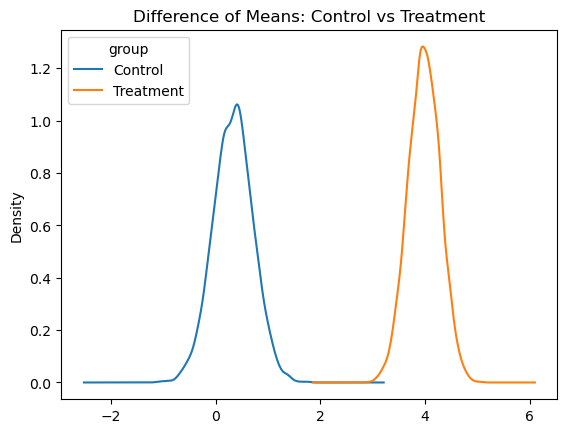

In [25]:
# kde plot
boot_means.plot(kind='kde')
plt.title('Difference of Means: Control vs Treatment');

- The Treatment group is clearly performing better. 
- We can look at the distribution of the differences as well.

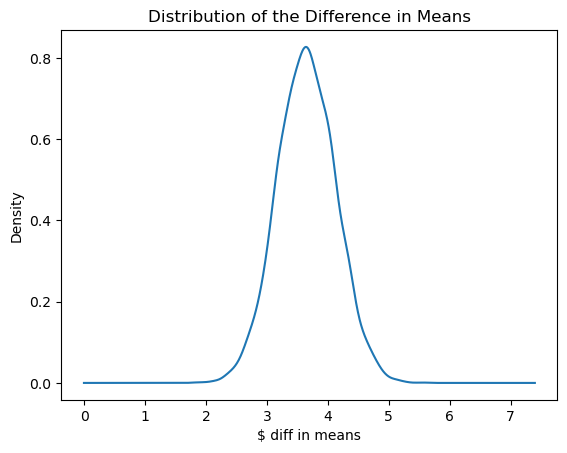

In [27]:
# create a new column, diff, which is the difference between the two variants, scaled by the control group
boot_means['treat_control_diff'] = (boot_means['Treatment'] - boot_means['Control'])

# plot the bootstrap sample difference
ax = boot_means['treat_control_diff'].plot(kind = 'kde')
ax.set_xlabel("$ diff in means")
plt.title('Distribution of the Difference in Means');

- The difference between the groups is centered at approximately 3.6 dollars
- If we calculate the confidence interval of the distribution in the graphic above, the result is almost the same as the Games-Howell test
    - i.e: the difference between the groups means is between 2.72 until 4.58 dollars, on a 95% confidence level.

In [28]:
# Mean and Std.
b_mu = boot_means.test_control_diff.mean()
b_std = boot_means.test_control_diff.std()


# create 95% confidence interval for the Test 
scs.norm(loc=b_mu, scale=b_std).interval(confidence= 0.95)

(np.float64(2.716438898869489), np.float64(4.584563176488669))